

In this preprocessing step, the same approach as the previous preprocessing for Problem 2 has been applied, with the same steps performed. However, there are two changes:

1. The lag numbers used for processing are **1, 2, 6, 7, 8, 9, 14, 21, 28**.
2. Due to better results with the **KNN imputation** method, only this method has been used to fill missing values.


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [22]:
df = pd.read_csv('data/Ridership.csv')
df["Date"] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Day'].astype(str) + '-' + df['Month'].astype(str))
df

,Year,Month,Day,Week Number,Corridor,Workday,Station,Period,Ridership,N_trains,Covid19,Date
0,2019,January,1,1,Corridor_1,n,Station_1,Weekend/Holiday,174,3,0,2019-01-01
1,2019,January,1,1,Corridor_1,n,Station_2,Weekend/Holiday,378,10,0,2019-01-01
2,2019,January,1,1,Corridor_1,n,Station_3,Weekend/Holiday,599,12,0,2019-01-01
3,2019,January,1,1,Corridor_2,n,Station_4,Weekend/Holiday,2759,35,0,2019-01-01
4,2019,January,1,1,Corridor_2,n,Station_5,Weekend/Holiday,2629,36,0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
64364,2022,December,31,52,Corridor_3,n,Station_30,Weekend/Holiday,2577,19,0,2022-12-31
64365,2022,December,31,52,Corridor_5,n,Station_19,Weekend/Holiday,74,2,0,2022-12-31
64366,2022,December,31,52,Corridor_7,n,Station_24,Weekend/Holiday,686,12,0,2022-12-31
64367,2022,December,31,52,Corridor_7,n,Station_21,Weekend/Holiday,82,3,0,2022-12-31


In [23]:
df = df.drop(df["Ridership"].sort_values(ascending=False).head(3).index).reset_index(drop=True)

from scipy.stats.mstats import winsorize
df["Ridership"] = winsorize(df["Ridership"], limits=[0, 8/df["Ridership"].count()])

In [24]:
df["Date"].head(1), df["Date"].tail(1)

(0   2019-01-01
 Name: Date, dtype: datetime64[ns],
 64365   2022-12-31
 Name: Date, dtype: datetime64[ns])

In [25]:
full_dates = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')

unique_groups = df[["Station", "Corridor", "Period"]].drop_duplicates().sort_values(by=["Station", "Corridor", "Period"])

full_index_df = pd.DataFrame([
    (station, corridor, period, date)
    for station, corridor, period in unique_groups.values
    for date in full_dates
], columns=['Station', 'Corridor', 'Period', 'Date'])

df_full = pd.merge(full_index_df, df, on=['Station', 'Corridor', 'Period', 'Date'], how='left')
df_full

,Station,Corridor,Period,Date,Year,Month,Day,Week Number,Workday,Ridership,N_trains,Covid19
0,Station_1,Corridor_1,AM Peak,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Station_1,Corridor_1,AM Peak,2019-01-02,2019.0,January,2.0,1.0,y,3519.0,6.0,0.0
2,Station_1,Corridor_1,AM Peak,2019-01-03,2019.0,January,3.0,1.0,y,3624.0,6.0,0.0
3,Station_1,Corridor_1,AM Peak,2019-01-04,2019.0,January,4.0,1.0,y,3181.0,6.0,0.0
4,Station_1,Corridor_1,AM Peak,2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
261514,Station_9,Corridor_4,Weekend/Holiday,2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261515,Station_9,Corridor_4,Weekend/Holiday,2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261516,Station_9,Corridor_4,Weekend/Holiday,2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261517,Station_9,Corridor_4,Weekend/Holiday,2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
max_lag = 370
df_full_sorted = df_full.sort_values("Date")
grouped = df_full_sorted.groupby(["Station", "Corridor", "Period"])

In [28]:
valid_counts = []

for lag_n in range(max_lag + 1):
    total_valid = 0

    for _, group_df in grouped:
        group_df = group_df.sort_values("Date")
        series = group_df["Ridership"]
        lagged = series.shift(lag_n)

        valid_rows = series.notna() & lagged.notna()
        total_valid += valid_rows.sum()
    
    valid_counts.append(total_valid)

lags = np.arange(max_lag + 1)

lags_summary = pd.DataFrame({
    "Lag": lags,
    "Valid_Record_Count": valid_counts
})

lags_summary.sort_values(by="Valid_Record_Count", ascending=False).reset_index(drop=True).head(15)

,Lag,Valid_Record_Count
0,0,64366
1,7,60548
2,14,59604
3,21,58858
4,28,58193
5,35,57901
6,42,56878
7,49,56205
8,56,55486
9,63,54798


In [29]:
lags_summary.sort_values(by="Lag", ascending=False).reset_index(drop=True).head(15)

,Lag,Valid_Record_Count
0,370,30511
1,369,21925
2,368,20893
3,367,21069
4,366,22286
5,365,30948
6,364,39001
7,363,30797
8,362,22109
9,361,21045


In [8]:
from statsmodels.tsa.stattools import acf

acf_all = []

for _, group_df in grouped:
    ridership_series = group_df["Ridership"].values
    acf_vals = acf(ridership_series, nlags=max_lag, missing='conservative')
    acf_all.append(acf_vals)

acf_array = np.array(acf_all)
acf_mean = np.nanmean(acf_array, axis=0)

lags = np.arange(len(acf_mean))
acf_summary = pd.DataFrame({
    "Lag": lags,
    "Mean_ACF": acf_mean
})

acf_summary.sort_values(by="Mean_ACF", ascending=False).reset_index(drop=True).head(15)

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


,Lag,Mean_ACF
0,0,1.000000
1,7,0.482048
2,14,0.439787
3,21,0.417640
4,28,0.397002
5,1,0.388157
6,35,0.382737
7,42,0.356407
8,49,0.344744
9,6,0.337683


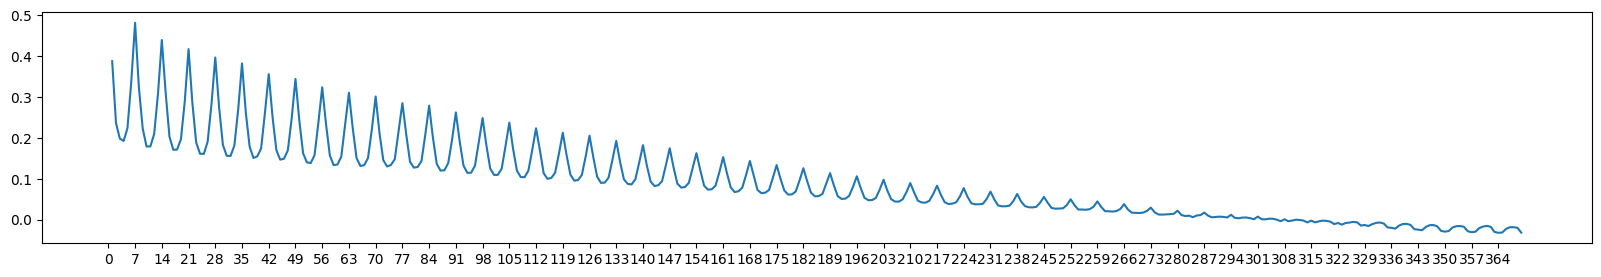

In [9]:
fig, ax = plt.subplots(figsize=(20, 3))
ax = plt.plot(acf_summary['Mean_ACF'].drop(0))
plt.xticks(np.arange(0, 370, 7))
plt.show()

In [10]:
from sklearn.feature_selection import mutual_info_regression

mi_all = []

for _, group_df in grouped:
    group_df = group_df.sort_values("Date").copy()
    mi_vals = []

    for lag in range(max_lag + 1):
        if lag == 0:
            mi_vals.append(1)
            continue

        shifted = group_df["Ridership"].shift(lag)
        valid = ~shifted.isna() & ~group_df["Ridership"].isna()

        X = shifted[valid].values.reshape(-1, 1)
        y = group_df["Ridership"][valid].values

        if len(X) > 3: 
            neighbors = min(3, len(X) - 1)
            mi = mutual_info_regression(X, y, discrete_features=False, n_neighbors=neighbors)
            mi_vals.append(mi[0])
        else:
            mi_vals.append(np.nan)

    mi_all.append(mi_vals)


mi_array = np.array(mi_all)
mi_mean = np.nanmean(mi_array, axis=0)
lags = np.arange(len(mi_mean))

mi_summary = pd.DataFrame({
    "Lag": lags,
    "Mean_MI": mi_mean
})

mi_summary.sort_values(by='Mean_MI', ascending=False).reset_index(drop=True).head(15)


,Lag,Mean_MI
0,0,1.000000
1,1,0.961082
2,7,0.935639
3,2,0.909143
4,5,0.833013
5,14,0.827625
6,6,0.825883
7,8,0.794006
8,3,0.777105
9,9,0.767267


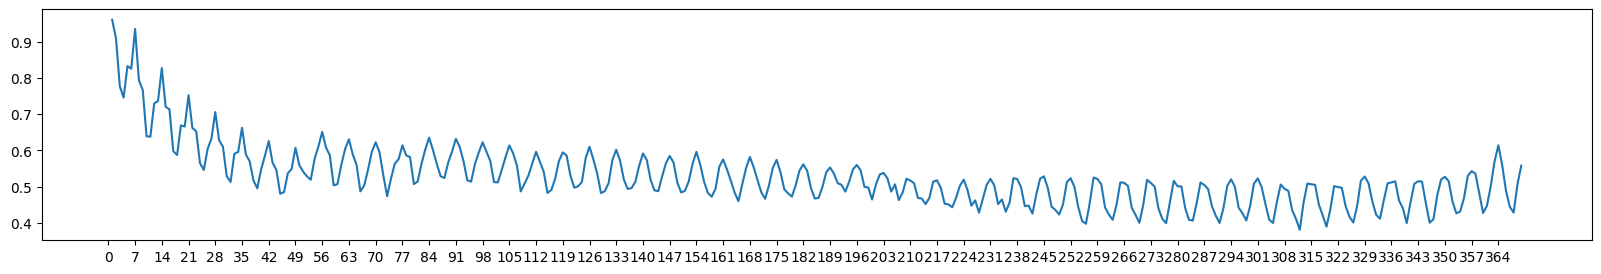

In [11]:
fig, ax = plt.subplots(figsize=(20, 3))
ax = plt.plot(mi_summary['Mean_MI'].drop(0))
plt.xticks(np.arange(0, 370, 7))
plt.show()

In [6]:
lag_list = [1, 2, 6, 7, 8, 9, 14, 21, 28]

In [7]:
for i in lag_list:
    df_full[f"lag_{i}"] = df_full["Ridership"].shift(i)

df_full = df_full[df_full["Ridership"].notna()]
df_full = df_full.reset_index(drop=True)
df_full.sample(3)

,Station,Corridor,Period,Date,Year,Month,Day,Week Number,Workday,Ridership,...,Covid19,lag_1,lag_2,lag_6,lag_7,lag_8,lag_9,lag_14,lag_21,lag_28
50974,Station_4,Corridor_3,Evening,2022-05-20,2022.0,May,20.0,20.0,y,1514.0,...,0.0,809.0,1210.0,NaN,1662.0,928.0,741.0,1202.0,2025.0,836.0
16443,Station_20,Corridor_6,Midday,2019-07-22,2019.0,July,22.0,30.0,y,774.0,...,0.0,NaN,NaN,780.0,779.0,NaN,NaN,779.0,NaN,835.0
37291,Station_3,Corridor_4,Midday,2020-06-15,2020.0,June,15.0,25.0,y,61.0,...,1.0,NaN,NaN,56.0,58.0,NaN,NaN,58.0,44.0,NaN


In [8]:
for i in lag_list:
    df_full.loc[df_full[f"lag_{i}"] != -1, f"lag_{i}"] = np.log1p(df_full[f"lag_{i}"])
df_full['Ridership'] = np.log1p(df_full['Ridership'])

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def encode_categorical_features(df):

    df['Year'] = df['Year'].astype(int)
    df['Day'] = df['Day'].astype(int)
    df['Weekday_Name'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Day'].astype(str) + '-' + df['Month'].astype(str)).dt.day_name()

    def convert_day_to_circle(day):
        angle = 2 * np.pi * (day - 1) / 31  # Calculate the angle based on the day
        x = np.cos(angle)  # Compute the x-coordinate on the unit circle
        y = np.sin(angle)  # Compute the y-coordinate on the unit circle
        return x, y


    categorical_features = ['Month', 'Corridor', 'Station', 'Period', 'Weekday_Name']

    df['day_x'], df['day_y'] = zip(*df['Day'].map(convert_day_to_circle))
    X = df.drop(columns=['Ridership', 'Day', 'Year', 'Workday', 'N_trains', 'Date'], axis=1)  # Features (excluding the target column) and also Day which is already converted

    # Create a ColumnTransformer to apply OneHotEncoder to categorical features
    preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features), 
    ],
    remainder='passthrough'
    )

    # Apply the ColumnTransformer to encode categorical features
    X_encoded = preprocessor.fit_transform(X)

    # Convert the encoded features to a dense matrix
    X_encoded = X_encoded.toarray()

    feature_names_out = list(preprocessor.get_feature_names_out())
    # Convert the dense matrix to a DataFrame
    X_encoded = pd.DataFrame(X_encoded, columns=[item.split('__')[1] for item in feature_names_out])

    return X_encoded

In [10]:
# Since we're trying to predict the ridership for different stations we have to apply the 80% to each of the stations separately

def split_the_timeseries_data(df, X_encoded):
    # Create empty lists to store the train-test split data
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []


    # Iterate over each unique station
    for station in df['Station'].unique():
        # Get the data for the current station
        station_data = X_encoded[X_encoded['Station_'+station] == 1]
        target_data = df.loc[X_encoded['Station_'+station] == 1, 'Ridership']

        # Determine the number of samples to include in the test set
        test_size = int(len(station_data) * 0.15)

        # Split the data into trainval and test sets
        station_X_trainval = station_data[:-test_size]
        station_X_test = station_data[-test_size:]
        station_y_trainval = target_data[:-test_size]
        station_y_test = target_data[-test_size:]

        # Determine the number of samples to include in the val set
        val_size = int(len(station_X_trainval) * 0.15)

        # Split the data into train and val sets
        station_X_train = station_X_trainval[:-val_size]
        station_X_val = station_X_trainval[-val_size:]
        station_y_train = station_y_trainval[:-val_size]
        station_y_val = station_y_trainval[-val_size:]

        # Append the station-specific data to the overall train-test split
        X_train.append(station_X_train)
        X_val.append(station_X_val)
        X_test.append(station_X_test)
        y_train.append(station_y_train)
        y_val.append(station_y_val)
        y_test.append(station_y_test)

    # Concatenate the train-test split data
    X_train = pd.concat(X_train)
    X_val = pd.concat(X_val)
    X_test = pd.concat(X_test)
    y_train = pd.concat(y_train)
    y_val = pd.concat(y_val)
    y_test = pd.concat(y_test)

    return X_train, X_val ,X_test, y_train, y_val, y_test

In [11]:
X_encoded = encode_categorical_features(df_full)
X_train, X_val ,X_test, y_train, y_val, y_test = split_the_timeseries_data(df_full, X_encoded)

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def run_knn_imputation(X_train, X_val, X_test, y_train, y_val, y_test, lag_list):

    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    X_train['Ridership'] = y_train
    X_val['Ridership'] = y_val
    X_test['Ridership'] = y_test 

    feature_cols = [col for col in X_train.columns if not col.startswith('lag_')]

    for lag in lag_list:
        lag_col = f"lag_{lag}"

        train_with_val = X_train[X_train[lag_col].notna()]
        train_missing = X_train[X_train[lag_col].isna()]
        val_with_val = X_val[X_val[lag_col].notna()] 
        test_with_val = X_test[X_test[lag_col].notna()] 

        if train_with_val.empty:
            print(f"Skipping {lag_col}, no available training data.")
            continue

        X_train_model = train_with_val[feature_cols].copy()
        y_train_model = train_with_val[lag_col]

        X_val_model = val_with_val[feature_cols].copy()
        y_val_model = val_with_val[lag_col]

        X_test_model = test_with_val[feature_cols].copy()
        y_test_model = test_with_val[lag_col]

        X_combined = pd.concat([X_train_model, X_val_model, X_test_model])
        y_combined = pd.concat([y_train_model, y_val_model, y_test_model])

        train_indices = np.arange(len(X_train_model))
        val_test_indices = np.arange(len(X_train_model), len(X_combined))
        cv_split = [(train_indices, val_test_indices)]

        knn = KNeighborsRegressor()
        param_grid = {
            'n_neighbors': np.arange(1, 51),
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski'],
            'p': [1, 2],
        }
        grid = GridSearchCV(knn, param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=8)
        grid.fit(X_combined, y_combined)

        best_knn = grid.best_estimator_
        print(f"Best KNN for {lag_col}: {grid.best_params_}")

        if not train_missing.empty:
            X_pred_features = train_missing[feature_cols].copy()
            preds = best_knn.predict(X_pred_features)
            X_train.loc[train_missing.index, lag_col] = preds

    return X_train

In [13]:
x_index = X_val.copy()
X_val = X_val.dropna()
val_indices_to_drop = x_index.index.difference(X_val.index)
y_val = y_val.drop(val_indices_to_drop)
print("val:", X_val.shape, y_val.shape)

x_index = X_test.copy()
X_test = X_test.dropna()
test_indices_to_drop = x_index.index.difference(X_test.index)
y_test = y_test.drop(test_indices_to_drop)
print("test:", X_test.shape, y_test.shape)

val: (2555, 89) (2555,)
test: (2160, 89) (2160,)


In [14]:
X_train_covid = X_train[X_train['Covid19'] == 1]
X_val_covid = X_val[X_val['Covid19'] == 1]
X_test_covid = X_test[X_test['Covid19'] == 1]
y_train_covid = y_train.loc[X_train_covid.index]
y_val_covid = y_val.loc[X_val_covid.index]
y_test_covid = y_test.loc[X_test_covid.index]

X_train_noncovid = X_train[X_train['Covid19'] == 0]
X_val_noncovid = X_val[X_val['Covid19'] == 0]
X_test_noncovid = X_test[X_test['Covid19'] == 0]
y_train_noncovid = y_train.loc[X_train_noncovid.index]
y_val_noncovid = y_val.loc[X_val_noncovid.index]
y_test_noncovid = y_test.loc[X_test_noncovid.index]

print("==== Imputing for Covid19 is 1 ====")
X_train_covid_filled = run_knn_imputation( X_train_covid, X_val_covid, X_test_covid,
                                           y_train_covid, y_val_covid, y_test_covid, lag_list)

print("==== Imputing for Covid19 is 0 ====")
X_train_noncovid_filled = run_knn_imputation(X_train_noncovid, X_val_noncovid, X_test_noncovid, 
                                             y_train_noncovid, y_val_noncovid, y_test_noncovid, lag_list)

X_train.loc[X_train_covid.index] = X_train_covid_filled

X_train.loc[X_train_noncovid.index] = X_train_noncovid_filled


==== Imputing for Covid19 is 1 ====
Best KNN for lag_1: {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_2: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
Best KNN for lag_6: {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Best KNN for lag_7: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_8: {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_9: {'metric': 'minkowski', 'n_neighbors': 18, 'p': 2, 'weights': 'distance'}
Best KNN for lag_14: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_21: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_28: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}
==== Imputing for Covid19 is 0 ====
Best KNN for lag_1: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'un

In [15]:
X_train.isnull().sum().sum(), X_val.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0, 0)

In [16]:
print("Train shape:", X_train.shape)
print("val  shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Train shape: (46516, 89)
val  shape: (2555, 89)
Test  shape: (2160, 89)


In [17]:
print("Train shape:", y_train.shape)
print("val  shape:", y_val.shape)
print("Test  shape:", y_test.shape)

Train shape: (46516,)
val  shape: (2555,)
Test  shape: (2160,)


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train['Week Number'] = scaler.fit_transform(X_train[['Week Number']])
X_val['Week Number'] = scaler.transform(X_val[['Week Number']])
X_test['Week Number'] = scaler.transform(X_test[['Week Number']])


In [19]:
X_train.to_csv("data\Q3\X_train3.csv", index=False)
X_test.to_csv("data\Q3\X_test3.csv", index=False)
X_val.to_csv("data\Q3\X_val3.csv", index=False)
y_train.to_csv("data\Q3\y_train3.csv", index=False)
y_test.to_csv("data\Q3\y_test3.csv", index=False)
y_val.to_csv("data\Q3\y_val3.csv", index=False)